# Analyzing models

In [4]:
import escher
from cameo import load_model, flux_variability_analysis
model = load_model('data/e_coli_core.xml.gz')

## Run flux variablity analysis

Calculate all flux ranges of all reactions in the model.

In [5]:
result = flux_variability_analysis(model)

Inspect the result.

In [6]:
result.data_frame

,lower_bound,upper_bound
ACALD,-20.000000,0.00
ACALDt,-20.000000,0.00
ACKr,-20.000000,0.00
ACONTa,0.000000,20.00
...,...,...
THD2,0.000000,333.22
TKT1,-0.154536,20.00
TKT2,-0.466373,20.00
TPI,-10.000000,10.00


Get an overview of a few key statistics of the resulting flux ranges.

In [7]:
result.data_frame.describe()

,lower_bound,upper_bound
count,95.000000,95.000000
mean,-7.282128,86.252959
std,14.716513,178.283105
min,-68.305000,-0.479429
25%,-10.000000,0.000000
50%,0.000000,20.000000
75%,0.000000,98.305000
max,8.390000,1000.000000


Visualize the flux ranges.

In [8]:
result.plot(index=result.data_frame.index, height=1200)

Visualize the flux ranges on a pathway map of _E. coli's_ central carbon metabolism.

In [9]:
abs_flux_ranges = abs(result.data_frame.lower_bound - result.data_frame.upper_bound).to_dict()
escher.Builder('e_coli_core.Core metabolism', reaction_data=abs_flux_ranges).display_in_notebook()

Those reactions showing up in red are futile cyles.

In [10]:
result.data_frame[result.data_frame.upper_bound > 500]

,lower_bound,upper_bound
FORt2,0.0,666.44
FORti,0.0,666.44
FRD7,0.0,1000.00
SUCDi,0.0,1000.00


In [11]:
result_no_cyles = flux_variability_analysis(model, remove_cycles=True)

In [12]:
abs_flux_ranges = abs(result_no_cyles.data_frame.lower_bound - result_no_cyles.data_frame.upper_bound).to_dict()
escher.Builder('e_coli_core.Core metabolism', reaction_data=abs_flux_ranges).display_in_notebook()

## Run flux variability analysis for optimally growing _E. coli_

(Optimal) Flux Balance Analysis solutions are not necessariliy unique. Flux Variablity Analysis is a good tool for estimating the space of alternative optimal solutions.

In [19]:
fba_solution = fba(model)

In [20]:
fba_solution.objective_value

0.8142975075325307

In [12]:
model_optimal = model.copy()

In [21]:
model_optimal.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = fba_solution.objective_value

In [22]:
result_max_obj = flux_variability_analysis(model_optimal, remove_cycles=True)

In [23]:
result_max_obj.plot(index=result_max_obj.data_frame.index, height=1200)

This is actually such a common task that `flux_variability_analysis` provides an option for fixing the objective's flux at a certain percentage.

In [26]:
result_max_obj = flux_variability_analysis(model, fraction_of_optimum=1., remove_cycles=True)

In [27]:
result_max_obj.plot(index=result_max_obj.data_frame.index, height=1200)

Turns out that in this small core metabolic model, the optimal solution is actually unique!

In [61]:
sum(abs(result_max_obj.data_frame.lower_bound - result_max_obj.data_frame.upper_bound))

1.2156704039782733e-12

## Exercises

### Exercise 1

Explore how relaxing the constraint on the growth rate affects the solution space:
1. Modify the code to explore flux ranges for $\mu \gt 0.7 \ h^{-1}$ 
1. Plot the sum of flux ranges over a range of percentages.

### Exercise 2

Using FVA, determine all blocked reactions ($v = 0$) in the model.

## Solutions

### Solution 1

In [14]:
percentage = (0.7 / model.solve().f) * 100
percentage

85.96366727452317

In [15]:
result_80perc_max_obj = flux_variability_analysis(model, fraction_of_optimum=percentage/100, remove_cycles=True)

In [16]:
result_80perc_max_obj.plot(index=result_80perc_max_obj.data_frame.index, height=1200)

### Solution 2

In [17]:
flux_sums = []
optimum_percentages = range(50, 105, 5)
for i in optimum_percentages:
    df = flux_variability_analysis(model, fraction_of_optimum=i/100, remove_cycles=True).data_frame
    flux_sum = sum(abs(df.lower_bound - df.upper_bound))
    print("{}%: ".format(i), flux_sum)
    flux_sums.append(flux_sum)

50%:  3054.41797584
55%:  2803.83006415
60%:  2546.38980185
65%:  2286.72971098
70%:  2022.42595388
75%:  1753.28867837
80%:  1459.23505356
85%:  1158.35585115
90%:  818.866128825
95%:  438.244124093
100%:  3.31157878897e-11


In [18]:
import matplotlib.pyplot as plt

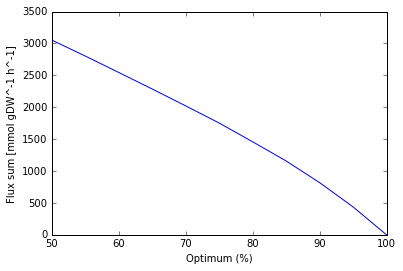

In [19]:
plt.plot(optimum_percentages, flux_sums)
plt.xlabel('Optimum (%)')
plt.ylabel('Flux sum [mmol gDW^-1 h^-1]')
plt.show()

### Solution 3

In [44]:
result = flux_variability_analysis(model, remove_cycles=True)

In [48]:
result.data_frame[(result.data_frame.lower_bound == 0) & (result.data_frame.upper_bound == 0)]

,upper_bound,lower_bound
EX_fru_e,0.0,0.0
EX_fum_e,0.0,0.0
EX_gln__L_e,0.0,0.0
EX_mal__L_e,0.0,0.0
FRD7,0.0,0.0
FRUpts2,0.0,0.0
FUMt2_2,0.0,0.0
GLNabc,0.0,0.0
MALt2_2,0.0,0.0


## Phenotypic phase plane analysis

Load a few packages.

In [12]:
import pandas
pandas.options.display.max_rows = 12
from cameo import models, phenotypic_phase_plane

Load a model _E. coli_ central carbon metabolism.

In [22]:
model = models.bigg.e_coli_core.copy()

Compute the phenotypic phase plane for growth and acetate secretion.

In [14]:
result = phenotypic_phase_plane(model,
                                variables=[model.reactions.BIOMASS_Ecoli_core_w_GAM],
                                objective=model.reactions.EX_ac_e)

Look at the result in a tabular view.

In [23]:
result.data_frame

,BIOMASS_Ecoli_core_w_GAM,objective_lower_bound,objective_upper_bound
0,0.000000,0.0,2.000000e+01
1,0.045996,0.0,1.930093e+01
2,0.091992,0.0,1.860186e+01
3,0.137988,0.0,1.790280e+01
4,0.183983,0.0,1.720373e+01
5,0.229979,0.0,1.650466e+01
...,...,...,...
14,0.643942,0.0,9.619970e+00
15,0.689938,0.0,7.906992e+00
16,0.735934,0.0,6.021404e+00


Plot the phenotypic phase plane.

In [24]:
result.plot()

We can also calculate a three dimensional phenotypic phase plane to compare the influence of aerobic and anaerobic environements.

In [25]:
result_3D = phenotypic_phase_plane(model, variables=[model.reactions.EX_ac_e, model.reactions.EX_o2_e], objective=model.reactions.BIOMASS_Ecoli_core_w_GAM, points=50)

In [26]:
result_3D.data_frame

,EX_ac_e,EX_o2_e,objective_lower_bound,objective_upper_bound
0,0.0,-6.000000e+01,0.0,-4.842084e-17
1,0.0,-5.877551e+01,0.0,2.801293e-02
2,0.0,-5.755102e+01,0.0,5.602585e-02
3,0.0,-5.632653e+01,0.0,8.403878e-02
4,0.0,-5.510204e+01,0.0,1.120517e-01
5,0.0,-5.387755e+01,0.0,1.400646e-01
...,...,...,...,...
2494,20.0,-6.122449e+00,0.0,0.000000e+00
2495,20.0,-4.897959e+00,0.0,0.000000e+00
2496,20.0,-3.673469e+00,0.0,0.000000e+00


Unfortunately, 3D plots are not yet supported out of the box.

In [18]:
result_3D.plot()

So let's quickly write a custom plot (you can use your mouse to rotate the graphic).

In [27]:
%matplotlib notebook

<IPython.core.display.Javascript object>


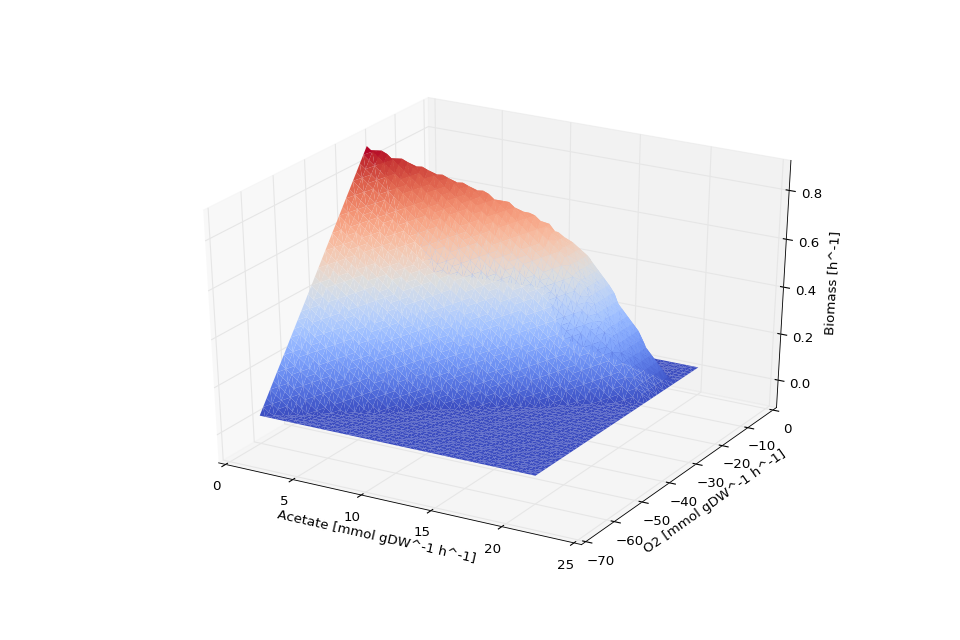

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    result_3D.data_frame.EX_ac_e.values,
    result_3D.data_frame.EX_o2_e.values,
    result_3D.data_frame.objective_upper_bound.values,
    cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('Acetate [mmol gDW^-1 h^-1]')
ax.set_ylabel('O2 [mmol gDW^-1 h^-1]')
ax.set_zlabel('Biomass [h^-1]')
ax.mouse_init()
# interact(f(fig, ax), angle=(0, 360), elevation=(-100, 100))